In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
model_save_name = 'NLP_model_1.pt'
path_google_drive = F"/content/gdrive/My Drive/{model_save_name}" 

In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [9]:
import torch
model_loaded = torch.load(path_google_drive)

In [ ]:
model_loaded.eval()

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Print the original sentence.
sentence = "Hello, my dog is cute"
print(' Original: ', sentence)

# Print the sentence split into tokens.
tokenized_texts = tokenizer.tokenize(sentence)
print('Tokenized: ', tokenized_texts)

# Print the sentence mapped to token ids.
b_input_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence))
print('Token IDs: ', b_input_ids)

100%|██████████| 231508/231508 [00:00<00:00, 912338.77B/s]

 Original:  Hello, my dog is cute
Tokenized:  ['hello', ',', 'my', 'dog', 'is', 'cute']
Token IDs:  [7592, 1010, 2026, 3899, 2003, 10140]


In [14]:
!cp gdrive/MyDrive/dontpatronizeme_categories.tsv .

In [15]:
!cp gdrive/MyDrive/dontpatronizeme_pcl.tsv .

In [17]:
!cp gdrive/MyDrive/test_me.py .
import test_me

In [19]:
from test_me import TestMe

i_test = TestMe()
i_test.load_test()

In [20]:
sentences = i_test.test_set

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence[:511] + " [SEP]" for sentence in sentences]
#labels = df.label.values
labels = i_test.test_label
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [25]:
# Prediction on test set

# Put model in evaluation mode
model_loaded.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model_loaded(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [28]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


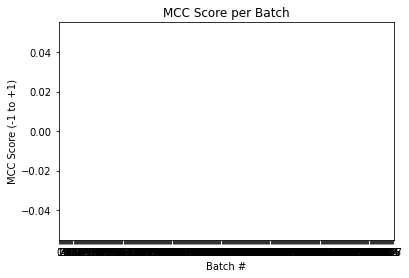

In [30]:
# Create a barplot showing the MCC score for each batch of test samples.
import seaborn as sns
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()